# Jupyter notebook based on ImageD11 to process scanning 3DXRD data
# Written by Haixing Fang, Jon Wright and James Ball
## Date: 21/02/2024

In [1]:
# There is a bug with the current version of ImageD11 in the site-wide Jupyter env.
# This has been fixed here: https://github.com/FABLE-3DXRD/ImageD11/commit/4af88b886b1775585e868f2339a0eb975401468f
# Until a new release has been made and added to the env, we need to get the latest version of ImageD11 from GitHub
# Put it in your home directory
# USER: Change the path below to point to your local copy of ImageD11:

import os

username = os.environ.get("USER")

id11_code_path = f"/home/esrf/{username}/Code/ImageD11"

import sys

sys.path.insert(0, id11_code_path)

In [2]:
# import functions we need

import os, glob, pprint
import numpy as np
import h5py
from tqdm.notebook import tqdm

import matplotlib
%matplotlib widget
from matplotlib import pyplot as plt

import utils

import ImageD11.grain
import ImageD11.indexing
import ImageD11.columnfile
from ImageD11.sinograms import properties, dataset

from ImageD11.blobcorrector import eiger_spatial

In [3]:
# NEW DATASETS

### USER: specify your experimental directory

base_dir = "/data/visitor/ma5837/id11/20240208"

rawdata_path = os.path.join(base_dir, 'RAW_DATA')

!ls -lrt {rawdata_path}

processed_data_root_dir = os.path.join(base_dir, 'PROCESSED_DATA')  # USER: modify this to change the destination folder if desired

total 2941
drwxr-x---  3 opid11 id11    4096 Feb  7 13:36 nanox_test
drwxr-x---  3 opid11 id11    4096 Feb  7 17:05 nanox_test_02_HC
drwxr-x---  3 opid11 id11    4096 Feb  7 17:34 nanox_test_no_sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:25 sample
drwxr-x---  3 opid11 id11    4096 Feb  8 08:26 test_stress_session
drwxr-x---  3 opid11 id11    4096 Feb  8 09:26 S06
drwxr-x--- 16 opid11 id11    4096 Feb  8 14:57 S20
drwxr-x---  3 opid11 id11    4096 Feb  8 16:26 S11
drwxr-x---  3 opid11 id11    4096 Feb  8 17:17 S05
drwxr-x--- 20 opid11 id11    4096 Feb  8 21:18 S20_HC1
drwxr-x--- 13 opid11 id11    4096 Feb  9 08:38 S18
drwxr-x---  3 opid11 id11    4096 Feb  9 10:14 empty_no_sample
drwxr-x--- 12 opid11 id11    4096 Feb  9 10:54 S17
drwxr-x--- 12 opid11 id11    4096 Feb  9 12:34 S16
drwxr-x---  2 opid11 id11    4096 Feb  9 13:59 test_fatigue_curvesave
drwxr-x---  2 opid11 id11    4096 Feb  9 14:11 S18_HC_fatigue_plots
drwxr-x---  2 opid11 id11    4096 Feb  9 14:47 S17_fatigue_plots


In [4]:
# USER: pick a sample you want to import

sample = "S14"

datasets = ["FF_zeries_0", "FF_zeries_1", "FF_zeries_2", "FF_zeries_3", "FF_zeries_4"]

In [5]:
# load all 3DXRD datasets for this sample

from collections import OrderedDict

ds_dict = OrderedDict()
for dataset in datasets:
    dset_path = os.path.join(processed_data_root_dir, sample, f"{sample}_{dataset}", f"{sample}_{dataset}_dataset.h5")
    ds = ImageD11.sinograms.dataset.load(dset_path)
    print(f"I have a DataSet {ds.dset} in sample {ds.sample}")
    ds_dict[dataset] = ds

I have a DataSet FF_zeries_0 in sample S14
I have a DataSet FF_zeries_1 in sample S14
I have a DataSet FF_zeries_2 in sample S14
I have a DataSet FF_zeries_3 in sample S14
I have a DataSet FF_zeries_4 in sample S14


In [6]:
def read_grains(ds):
    with h5py.File(ds.grainsfile, 'r') as hin:      
        grains_group = 'grains'
        
        grains = []
        for gid_string in tqdm(sorted(hin[grains_group].keys(), key=lambda x: int(x))):
            gg = hin[grains_group][gid_string]
            ubi = gg.attrs['ubi'][:]
            translation = gg.attrs['translation'][:]
            g = ImageD11.grain.grain(ubi, translation=translation)
            g.gid = int(gid_string)
            g.peaks_3d = gg['peaks_3d_indexing'][:]
            grains.append(g)
    
    return grains

In [7]:
# populate z translations

z_translation_motor = "samtz"

for ds in ds_dict.values():
    with h5py.File(ds.masterfile, 'r' ) as hin:
        this_z_trans_value = hin["1.1/instrument/positioners"][z_translation_motor][()]
    ds.zpos = this_z_trans_value  # this is in microns for samtz

In [8]:
# load grains for each dataset and tie them to the dataset objects
for ds in ds_dict.values():
    ds.grains = read_grains(ds)

  0%|          | 0/484 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

  0%|          | 0/479 [00:00<?, ?it/s]

  0%|          | 0/452 [00:00<?, ?it/s]

  0%|          | 0/461 [00:00<?, ?it/s]

In [10]:
# get positions within the sample (set middle slice as zero position)

middle_ds = list(ds_dict.values())[len(ds_dict.values())//2]
middle_pos = middle_ds.zpos

for ds in ds_dict.values():
    # adjust so that the first letterbox (lowest z so highest on the sample) has the highest value of zpos
    ds.zpos_sample = middle_pos - ds.zpos
    print(ds.zpos, ds.zpos_sample)

-3.1737 0.04999999999999982
-3.1487 0.024999999999999467
-3.1237000000000004 0.0
-3.0987 -0.025000000000000355
-3.0737 -0.050000000000000266


In [11]:
for inc, ds in enumerate(ds_dict.values()):
    for grain in ds.grains:
        grain.pos_sample = grain.translation + np.array([0., 0., ds.zpos_sample * 1000])
        grain.dataset = ds.dsname
        grain.z_slice = inc

In [12]:
all_grains = []
for ds in ds_dict.values():
    all_grains.extend(ds.grains)

In [13]:
print(all_grains[0].pos_sample, all_grains[0].translation)

[ 55.9766   -45.6584    49.805194] [ 55.9766   -45.6584    -0.194806]


/tmp/ipykernel_2579118/3782212449.py:16: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  scatterplot = ax.scatter(xx, yy, zz, c=colors[ds.grains[0].z_slice], label=ds.grains[0].z_slice)


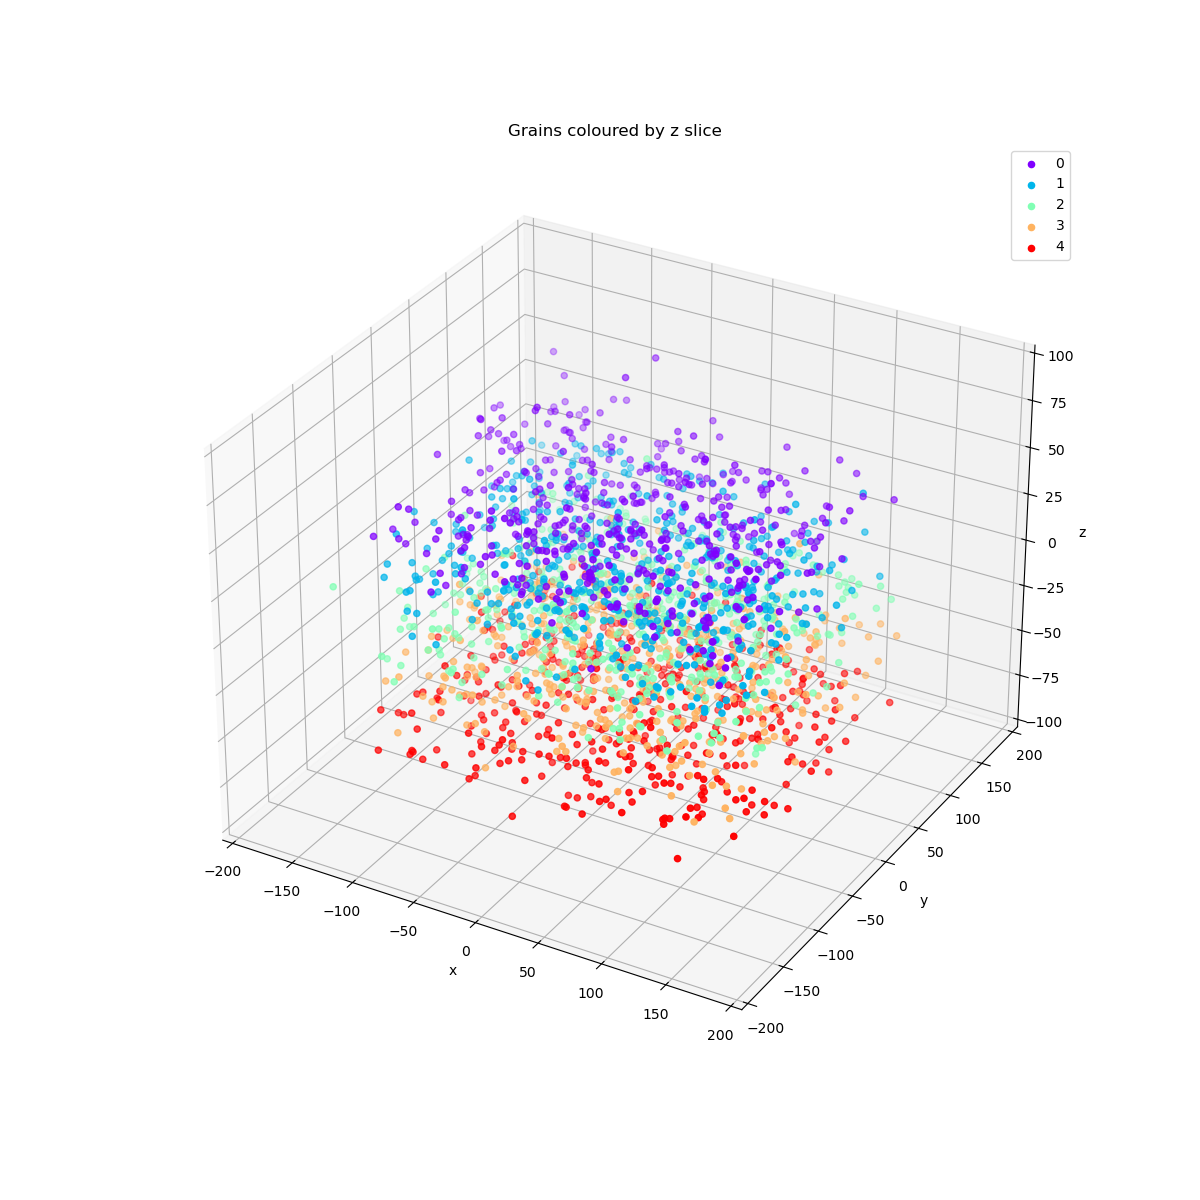

In [14]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

import matplotlib.cm as cm

colors = cm.rainbow(np.linspace(0, 1, len(list(ds_dict.values()))))

for ds in ds_dict.values():
    xx = [grain.pos_sample[0] for grain in ds.grains]
    yy = [grain.pos_sample[1] for grain in ds.grains]
    zz = [grain.pos_sample[2] for grain in ds.grains]
    # col = [len(grain.peaks_3d) for grain in ds.grains]
    # col = [grain.z_slice for grain in ds.grains]
    scatterplot = ax.scatter(xx, yy, zz, c=colors[ds.grains[0].z_slice], label=ds.grains[0].z_slice)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-100,100)
# plt.colorbar(scatterplot)
ax.set_title("Grains coloured by z slice")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

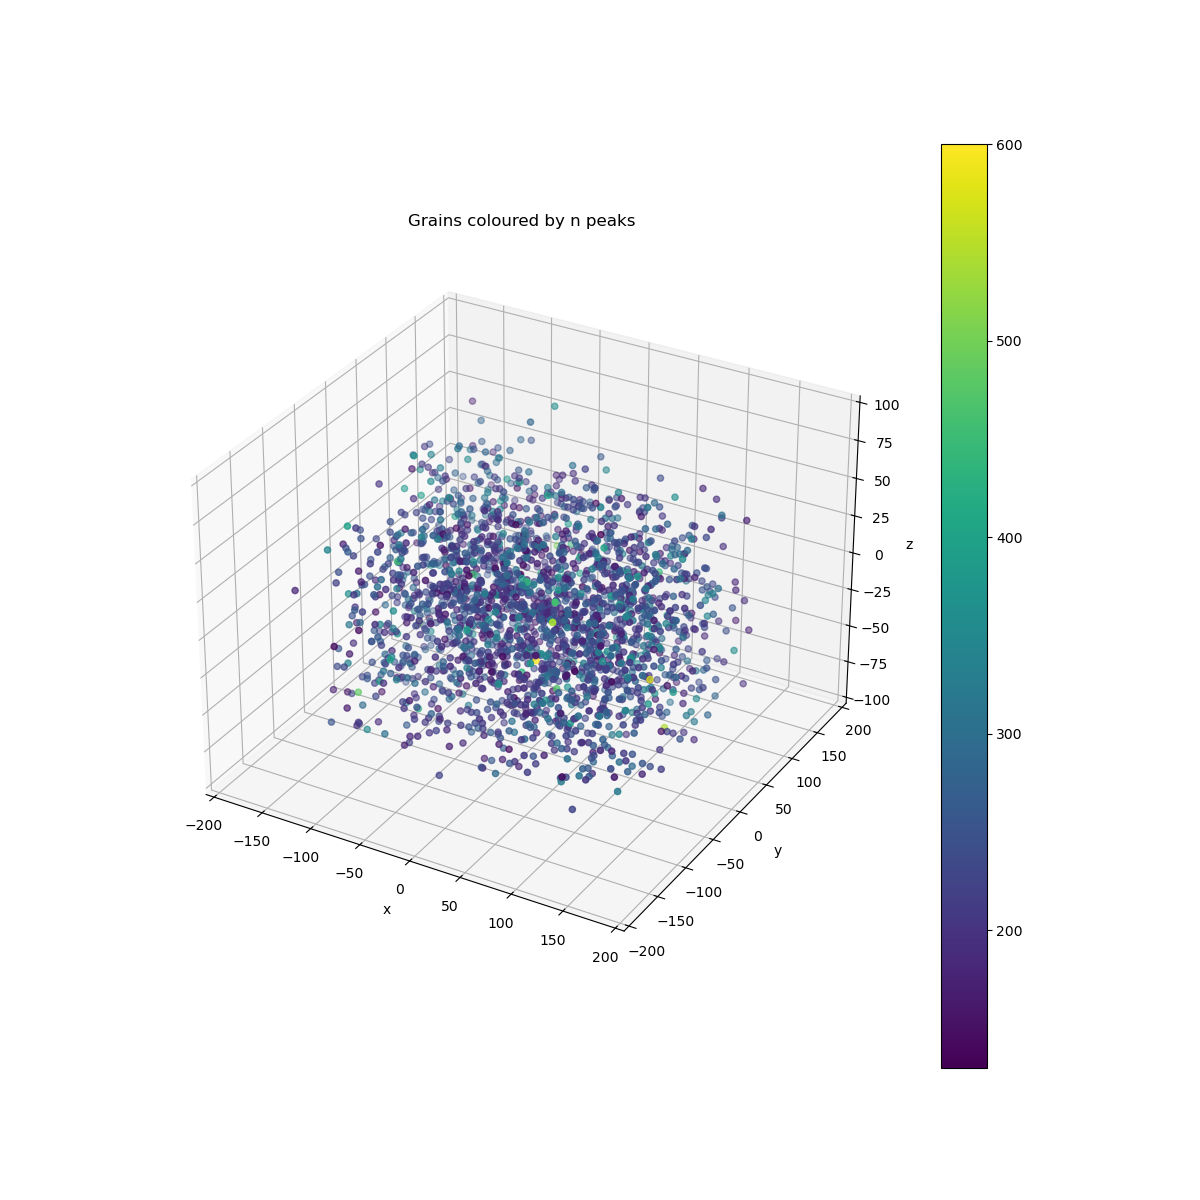

In [15]:
centre_plot = False

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')
xx = [grain.pos_sample[0] for grain in all_grains]
yy = [grain.pos_sample[1] for grain in all_grains]
zz = [grain.pos_sample[2] for grain in all_grains]
# col = [utils.grain_to_rgb(grain) for grain in grains_filtered]  # IPF-Z colour instead
col = [len(grain.peaks_3d) for grain in all_grains]
# sizes = [0.01*(float(grain.intensity_info.split("mean = ")[1].split(" , ")[0].replace("'", ""))) for grain in all_grains]
if centre_plot:
    scatterplot = ax.scatter(xx-np.mean(xx), yy-np.mean(yy), zz-np.mean(zz), c=col)
else:
    scatterplot = ax.scatter(xx, yy, zz, c=col)
ax.set_xlim(-200,200)
ax.set_ylim(-200,200)
ax.set_zlim(-100,100)
plt.colorbar(scatterplot)
ax.set_title("Grains coloured by n peaks")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

In [ ]:
# now we can look for duplicate grains
# this is a very simple duplicate grain detector

distance_tolerance = 25/2  # microns
angle_tolerance = 2  # degrees

def eudis(v1, v2):
    return np.linalg.norm(v1-v2)

from xfab.symmetry import Umis

def misorien_deg(U1, U2):
    return np.min(Umis(U1, U2, 7), axis=0)[1]  # 7 == cubic

matches = []

for grain_a in all_grains:
    for grain_b in all_grains:
        if grain_a.z_slice == grain_b.z_slice:
            # grains are in the same slice, skip
            continue
        translation = eudis(grain_a.pos_sample, grain_b.pos_sample)
        if translation < distance_tolerance:
            # might have a match in translation, now check misorientation
            misorien = misorien_deg(grain_a.U, grain_b.U)
            if misorien < angle_tolerance:
                print(f"Found match! Grain A: {grain_a.z_slice}:{grain_a.gid} | Grain B: {grain_b.z_slice}:{grain_b.gid} | Distance: {translation:.0f} um | Angle: {misorien:.3f} deg")
                matches.append((grain_a, grain_b))

In [ ]:
# how do we determine good choices of parameters?
# one way is to follow Louca and try a range of parameters and plot the results

In [ ]:
def get_n_matches(dist_tol, ang_tol):
    n_matches = 0
    for grain_a in all_grains:
        for grain_b in all_grains:
            if grain_a.z_slice == grain_b.z_slice:
                # grains are in the same slice, skip
                continue
            translation = eudis(grain_a.pos_sample, grain_b.pos_sample)
            if translation < dist_tol:
                # might have a match in translation, now check misorientation
                misorien = misorien_deg(grain_a.U, grain_b.U)
                if misorien < ang_tol:
                    n_matches += 1
    return n_matches

In [ ]:
dist_tols = [1, 2, 5, 10, 15, 20, 25]
ang_tols = [1, 2, 3, 4, 5]

tol_check_results = {}

print("dist_tol | ang_tol | n_matches")

for dist_tol in dist_tols:
    for ang_tol in ang_tols:

        n_matches = get_n_matches(dist_tol, ang_tol)
        tol_check_results[dist_tol, ang_tol] = n_matches
        print(f"{dist_tol} | {ang_tol} | {n_matches}")

In [ ]:
fig, ax = plt.subplots()

for ang_tol in ang_tols:
    n_matches_at_this_angle = []
    for dist_tol in dist_tols:
        n_matches_at_this_distance = tol_check_results[dist_tol, ang_tol]
        n_matches_at_this_angle.append(n_matches_at_this_distance)
    
    ax.plot(dist_tols, n_matches_at_this_angle, label=ang_tol)
    
ax.legend()

ax.set_xlabel("Distance tolerance (um)")
ax.set_ylabel("Number of merges")
ax.set_title("Legend is angle tolerance (deg)")

plt.show()

In [ ]:
# please note that this is a very simple duplicate grain detector
# it doesn't consider things like whether grains can match to multiple other grains
# or whether there could be duplicate grains within a single slice
# we're also not currently considering how to merge grains together
# this involves averaging the positions (easy) and the UBIs (not so easy)
# hopefully this notebook gives you a starting point though!